# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
!nvidia-smi

Sun May  2 13:31:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   48C    P0    74W / 149W |  11034MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [3]:
# Hier kann das Spiel übergeben werden
game = "SpaceInvaders-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [6]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [7]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [8]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [9]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [10]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

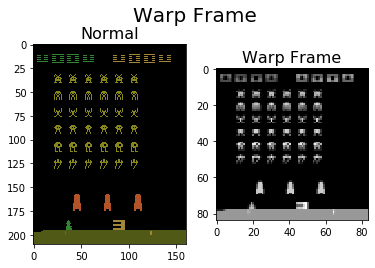

In [11]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [12]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

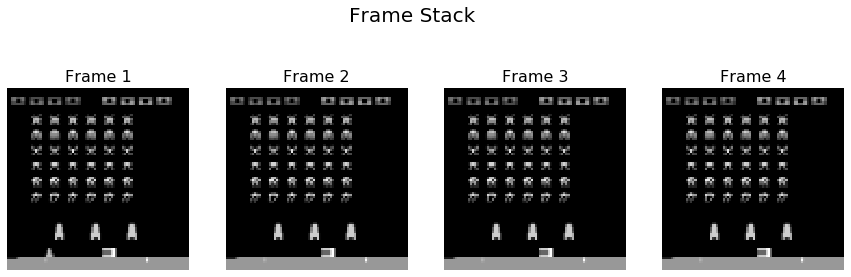

In [13]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [14]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)


""" saving the properties for csv """
MODE = "NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/SpaceInvaders-v0/NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife/


# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [15]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error" # Huber
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [16]:
#DQN.summary()
#TARGET.summary()

# **Memory Buffer**

In [17]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [18]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [19]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

Aktion auf Basis der Explorationsstrategie wählen

In [20]:
EPSILON = 1.0
EPSILON_MIN = 0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [21]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

215.0

# **Training des Agenten**

In [22]:
EPISODES = 5000#15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"Best.h5")

W0502 13:31:09.964869 139626999207744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: 125.0 	Mean: 125.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9964968356108187
Episode: 2 	Reward: 35.0 	Mean: 80.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9940974407166575
Episode: 3 	Reward: 85.0 	Mean: 81.67 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9917936424972283
Episode: 4 	Reward: 105.0 	Mean: 87.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9895313609591165
Episode: 5 	Reward: 35.0 	Mean: 77.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9879316446859594
Episode: 6 	Reward: 90.0 	Mean: 79.17 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9854489135265128
Episode: 7 	Reward: 210.0 	Mean: 97.86 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9818260050185849
Episode: 8 	Reward: 180.0 	Mean: 108.12 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9776209348389161
Episode: 9 	Reward: 80.0 	Mean: 105.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9758324130443345
Episode: 10 	Reward: 135.0 	Mean: 108.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.9733311109100

Episode: 82 	Reward: 110.0 	Mean: 178.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7920199352201384
Episode: 83 	Reward: 40.0 	Mean: 122.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7908997705034821
Episode: 84 	Reward: 275.0 	Mean: 135.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7871789669538954
Episode: 85 	Reward: 100.0 	Mean: 138.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7850794132704337
Episode: 86 	Reward: 165.0 	Mean: 129.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7828906630161085
Episode: 87 	Reward: 160.0 	Mean: 136.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7797701751514198
Episode: 88 	Reward: 85.0 	Mean: 126.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7778288099260581
Episode: 89 	Reward: 165.0 	Mean: 139.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7751769220871421
Episode: 90 	Reward: 80.0 	Mean: 132.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.7736257996409411
Episode: 91 	Reward: 155.0 	Mean: 133.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.

Episode: 163 	Reward: 50.0 	Mean: 118.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6413763879733305
Episode: 164 	Reward: 110.0 	Mean: 115.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.639733102812884
Episode: 165 	Reward: 255.0 	Mean: 136.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6379226428634283
Episode: 166 	Reward: 95.0 	Mean: 129.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6362898411452099
Episode: 167 	Reward: 165.0 	Mean: 133.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6343092351136719
Episode: 168 	Reward: 325.0 	Mean: 151.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6323998279301336
Episode: 169 	Reward: 145.0 	Mean: 150.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6307307143501526
Episode: 170 	Reward: 155.0 	Mean: 160.0 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6289504516661162
Episode: 171 	Reward: 205.0 	Mean: 162.5 	BestMean: 215.0 	TRAIN START: True 	Epsi: 0.6266597810566196
Episode: 172 	Reward: 30.0 	Mean: 153.5 	BestMean: 215.0 	TRAIN START: True 

Episode: 243 	Reward: 625.0 	Mean: 212.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5174792169637489
Episode: 244 	Reward: 125.0 	Mean: 208.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.515696224241367
Episode: 245 	Reward: 100.0 	Mean: 209.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5142438306279971
Episode: 246 	Reward: 150.0 	Mean: 212.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5129203690378853
Episode: 247 	Reward: 190.0 	Mean: 230.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5112061882707598
Episode: 248 	Reward: 215.0 	Mean: 218.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5096629560974804
Episode: 249 	Reward: 85.0 	Mean: 216.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5082724672173492
Episode: 250 	Reward: 50.0 	Mean: 216.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5070332035521776
Episode: 251 	Reward: 75.0 	Mean: 206.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.5061387148027643
Episode: 252 	Reward: 305.0 	Mean: 192.0 	BestMean: 245.5 	TRAIN START: True 

Episode: 323 	Reward: 25.0 	Mean: 121.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.4128283893437199
Episode: 324 	Reward: 185.0 	Mean: 136.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.4115234958037296
Episode: 325 	Reward: 240.0 	Mean: 141.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.4099015800386634
Episode: 326 	Reward: 65.0 	Mean: 128.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.4090165277478097
Episode: 327 	Reward: 195.0 	Mean: 141.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.40762907747737465
Episode: 328 	Reward: 75.0 	Mean: 129.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.40716797977089425
Episode: 329 	Reward: 110.0 	Mean: 125.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.40584387622119655
Episode: 330 	Reward: 220.0 	Mean: 132.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.4044463141282806
Episode: 331 	Reward: 165.0 	Mean: 140.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.4035950567651845
Episode: 332 	Reward: 190.0 	Mean: 147.0 	BestMean: 245.5 	TRAIN START: T

Episode: 403 	Reward: 150.0 	Mean: 147.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.33784394452217115
Episode: 404 	Reward: 140.0 	Mean: 151.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.3372026320334184
Episode: 405 	Reward: 90.0 	Mean: 133.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.33675237491227233
Episode: 406 	Reward: 35.0 	Mean: 127.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.3360715089900674
Episode: 407 	Reward: 175.0 	Mean: 123.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.3351855467690217
Episode: 408 	Reward: 70.0 	Mean: 120.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.3346358559786309
Episode: 409 	Reward: 300.0 	Mean: 143.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.333456266327374
Episode: 410 	Reward: 70.0 	Mean: 139.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.3331016823546449
Episode: 411 	Reward: 290.0 	Mean: 165.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.33204579938471573
Episode: 412 	Reward: 40.0 	Mean: 136.0 	BestMean: 245.5 	TRAIN START: True

Episode: 483 	Reward: 85.0 	Mean: 148.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.2784011673068458
Episode: 484 	Reward: 425.0 	Mean: 186.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.2777671883034257
Episode: 485 	Reward: 50.0 	Mean: 186.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.2773765303704498
Episode: 486 	Reward: 355.0 	Mean: 209.0 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.27668964285611336
Episode: 487 	Reward: 220.0 	Mean: 226.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.27580136739059236
Episode: 488 	Reward: 85.0 	Mean: 205.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.2753448775293523
Episode: 489 	Reward: 230.0 	Mean: 221.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.27439010340335024
Episode: 490 	Reward: 120.0 	Mean: 210.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.27367656772707716
Episode: 491 	Reward: 130.0 	Mean: 200.5 	BestMean: 245.5 	TRAIN START: True 	Epsi: 0.27308014676629905
Episode: 492 	Reward: 160.0 	Mean: 186.0 	BestMean: 245.5 	TRAIN START:

Episode: 563 	Reward: 250.0 	Mean: 145.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.23385736106336444
Episode: 564 	Reward: 115.0 	Mean: 147.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.2333123356381524
Episode: 565 	Reward: 30.0 	Mean: 141.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.23291299793729248
Episode: 566 	Reward: 165.0 	Mean: 146.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.23249365577337813
Episode: 567 	Reward: 90.0 	Mean: 137.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.2320571473443652
Episode: 568 	Reward: 365.0 	Mean: 154.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.23128818117060462
Episode: 569 	Reward: 105.0 	Mean: 157.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.23085564425118585
Episode: 570 	Reward: 220.0 	Mean: 176.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.23019779098692902
Episode: 571 	Reward: 310.0 	Mean: 186.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.22955101778976064
Episode: 572 	Reward: 140.0 	Mean: 179.0 	BestMean: 256.0 	TRAIN STA

Episode: 643 	Reward: 170.0 	Mean: 111.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.19992648476931868
Episode: 644 	Reward: 120.0 	Mean: 110.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.19958531991584036
Episode: 645 	Reward: 435.0 	Mean: 131.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.19885308552315967
Episode: 646 	Reward: 155.0 	Mean: 142.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.19845649380280445
Episode: 647 	Reward: 230.0 	Mean: 159.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1979086365107542
Episode: 648 	Reward: 310.0 	Mean: 179.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.19735993327386386
Episode: 649 	Reward: 90.0 	Mean: 184.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1970682911559507
Episode: 650 	Reward: 130.0 	Mean: 188.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.19677945822312184
Episode: 651 	Reward: 95.0 	Mean: 186.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.19648955492083334
Episode: 652 	Reward: 75.0 	Mean: 181.0 	BestMean: 256.0 	TRAIN STAR

Episode: 723 	Reward: 180.0 	Mean: 182.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.17435082457716164
Episode: 724 	Reward: 55.0 	Mean: 180.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.17414293345174334
Episode: 725 	Reward: 115.0 	Mean: 158.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1737628165112163
Episode: 726 	Reward: 285.0 	Mean: 164.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1733670381567895
Episode: 727 	Reward: 110.0 	Mean: 159.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.17306977184082917
Episode: 728 	Reward: 40.0 	Mean: 150.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.17296170856505394
Episode: 729 	Reward: 60.0 	Mean: 140.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.17275770152421355
Episode: 730 	Reward: 175.0 	Mean: 150.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1723731057851179
Episode: 731 	Reward: 255.0 	Mean: 156.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1720395132285572
Episode: 732 	Reward: 160.0 	Mean: 143.5 	BestMean: 256.0 	TRAIN START:

Episode: 803 	Reward: 140.0 	Mean: 175.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.15565070595827116
Episode: 804 	Reward: 110.0 	Mean: 174.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1553543232346201
Episode: 805 	Reward: 245.0 	Mean: 189.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.15504080192208708
Episode: 806 	Reward: 110.0 	Mean: 177.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.15487043963410674
Episode: 807 	Reward: 410.0 	Mean: 188.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.15451929977665746
Episode: 808 	Reward: 70.0 	Mean: 183.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.15434294309747815
Episode: 809 	Reward: 105.0 	Mean: 189.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1542180979553033
Episode: 810 	Reward: 120.0 	Mean: 160.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.15405028210060917
Episode: 811 	Reward: 200.0 	Mean: 168.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.15380437391101223
Episode: 812 	Reward: 125.0 	Mean: 163.5 	BestMean: 256.0 	TRAIN ST

Episode: 883 	Reward: 125.0 	Mean: 190.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.14018503904616114
Episode: 884 	Reward: 235.0 	Mean: 206.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.14001101388445733
Episode: 885 	Reward: 200.0 	Mean: 186.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13988079035887097
Episode: 886 	Reward: 30.0 	Mean: 168.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13976132727202192
Episode: 887 	Reward: 95.0 	Mean: 151.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13964697938946663
Episode: 888 	Reward: 80.0 	Mean: 138.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1395582695477495
Episode: 889 	Reward: 30.0 	Mean: 134.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13948002166501244
Episode: 890 	Reward: 170.0 	Mean: 127.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13932084413260387
Episode: 891 	Reward: 75.0 	Mean: 131.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13920776301647086
Episode: 892 	Reward: 65.0 	Mean: 110.5 	BestMean: 256.0 	TRAIN START:

Episode: 963 	Reward: 35.0 	Mean: 197.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13014366434632949
Episode: 964 	Reward: 250.0 	Mean: 209.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.13001192381886123
Episode: 965 	Reward: 25.0 	Mean: 174.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12994597016208348
Episode: 966 	Reward: 475.0 	Mean: 187.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1297674276347334
Episode: 967 	Reward: 120.0 	Mean: 181.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12966164399894703
Episode: 968 	Reward: 120.0 	Mean: 188.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.129591725055914
Episode: 969 	Reward: 115.0 	Mean: 186.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12947595255604508
Episode: 970 	Reward: 60.0 	Mean: 173.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12938178026389352
Episode: 971 	Reward: 245.0 	Mean: 164.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12923874646253625
Episode: 972 	Reward: 225.0 	Mean: 167.0 	BestMean: 256.0 	TRAIN START

Episode: 1042 	Reward: 145.0 	Mean: 205.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12165279971817164
Episode: 1043 	Reward: 170.0 	Mean: 206.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12159182483795554
Episode: 1044 	Reward: 185.0 	Mean: 187.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12150261946565906
Episode: 1045 	Reward: 175.0 	Mean: 189.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12143434974214952
Episode: 1046 	Reward: 300.0 	Mean: 207.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.1213120952428233
Episode: 1047 	Reward: 125.0 	Mean: 196.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12122362108046235
Episode: 1048 	Reward: 365.0 	Mean: 215.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12112030211291037
Episode: 1049 	Reward: 60.0 	Mean: 182.5 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12103178286458091
Episode: 1050 	Reward: 255.0 	Mean: 194.0 	BestMean: 256.0 	TRAIN START: True 	Epsi: 0.12094866169297966
Episode: 1051 	Reward: 120.0 	Mean: 190.0 	BestMean: 256.

Episode: 1121 	Reward: 205.0 	Mean: 274.0 	BestMean: 280.5 	TRAIN START: True 	Epsi: 0.11561473099629856
Episode: 1122 	Reward: 490.0 	Mean: 300.5 	BestMean: 280.5 	TRAIN START: True 	Epsi: 0.11551263360653585
Episode: 1123 	Reward: 240.0 	Mean: 305.0 	BestMean: 300.5 	TRAIN START: True 	Epsi: 0.11544113053854319
Episode: 1124 	Reward: 150.0 	Mean: 312.0 	BestMean: 305.0 	TRAIN START: True 	Epsi: 0.1153711866985528
Episode: 1125 	Reward: 65.0 	Mean: 271.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11533526017210739
Episode: 1126 	Reward: 165.0 	Mean: 258.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11525023272090676
Episode: 1127 	Reward: 120.0 	Mean: 261.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11518327910291283
Episode: 1128 	Reward: 110.0 	Mean: 209.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11511782881160573
Episode: 1129 	Reward: 235.0 	Mean: 204.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11505506927409506
Episode: 1130 	Reward: 700.0 	Mean: 248.0 	BestMean: 312.

Episode: 1200 	Reward: 190.0 	Mean: 286.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11105557431127705
Episode: 1201 	Reward: 395.0 	Mean: 300.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11098834057934114
Episode: 1202 	Reward: 300.0 	Mean: 306.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11093353600206378
Episode: 1203 	Reward: 65.0 	Mean: 263.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11090209271843984
Episode: 1204 	Reward: 70.0 	Mean: 228.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11088357490541928
Episode: 1205 	Reward: 555.0 	Mean: 273.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11080916908532315
Episode: 1206 	Reward: 145.0 	Mean: 267.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11077959250045472
Episode: 1207 	Reward: 315.0 	Mean: 271.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11073527194239535
Episode: 1208 	Reward: 90.0 	Mean: 259.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.11068878181870617
Episode: 1209 	Reward: 130.0 	Mean: 225.5 	BestMean: 312.0

Episode: 1279 	Reward: 100.0 	Mean: 212.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10793429706429725
Episode: 1280 	Reward: 195.0 	Mean: 202.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10791147916230268
Episode: 1281 	Reward: 440.0 	Mean: 232.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10786289424583749
Episode: 1282 	Reward: 280.0 	Mean: 239.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10781195117757333
Episode: 1283 	Reward: 135.0 	Mean: 230.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10779104317765147
Episode: 1284 	Reward: 445.0 	Mean: 239.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10774226873853336
Episode: 1285 	Reward: 110.0 	Mean: 240.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10772031188880048
Episode: 1286 	Reward: 150.0 	Mean: 211.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10769010750546543
Episode: 1287 	Reward: 70.0 	Mean: 206.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.1076661517604435
Episode: 1288 	Reward: 525.0 	Mean: 245.0 	BestMean: 312.

Episode: 1358 	Reward: 285.0 	Mean: 216.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10551943093408989
Episode: 1359 	Reward: 110.0 	Mean: 208.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.1055055394787211
Episode: 1360 	Reward: 155.0 	Mean: 211.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10547972415669955
Episode: 1361 	Reward: 100.0 	Mean: 178.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.1054645116786857
Episode: 1362 	Reward: 330.0 	Mean: 201.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.1054278047114101
Episode: 1363 	Reward: 300.0 	Mean: 203.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10540246193371612
Episode: 1364 	Reward: 395.0 	Mean: 210.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10536456216541813
Episode: 1365 	Reward: 295.0 	Mean: 225.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.1053437879921743
Episode: 1366 	Reward: 215.0 	Mean: 235.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10531075900229424
Episode: 1367 	Reward: 315.0 	Mean: 250.0 	BestMean: 312.0 

Episode: 1437 	Reward: 230.0 	Mean: 199.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10387945532382835
Episode: 1438 	Reward: 180.0 	Mean: 197.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10386273222473122
Episode: 1439 	Reward: 225.0 	Mean: 206.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10384731215652877
Episode: 1440 	Reward: 145.0 	Mean: 206.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10382743460685845
Episode: 1441 	Reward: 180.0 	Mean: 201.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10381535900300337
Episode: 1442 	Reward: 160.0 	Mean: 196.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10379215615372349
Episode: 1443 	Reward: 240.0 	Mean: 206.0 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10377331816161077
Episode: 1444 	Reward: 560.0 	Mean: 242.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.10375172135748782
Episode: 1445 	Reward: 195.0 	Mean: 237.5 	BestMean: 312.0 	TRAIN START: True 	Epsi: 0.1037340549581811
Episode: 1446 	Reward: 540.0 	Mean: 265.5 	BestMean: 312

Episode: 1516 	Reward: 365.0 	Mean: 283.5 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10266108720593475
Episode: 1517 	Reward: 270.0 	Mean: 296.5 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10264152067167293
Episode: 1518 	Reward: 60.0 	Mean: 269.0 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10263561028747002
Episode: 1519 	Reward: 180.0 	Mean: 252.0 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.1026252989186301
Episode: 1520 	Reward: 385.0 	Mean: 265.5 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10261220518564801
Episode: 1521 	Reward: 270.0 	Mean: 283.0 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10260110086056265
Episode: 1522 	Reward: 475.0 	Mean: 299.5 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10258916327410285
Episode: 1523 	Reward: 400.0 	Mean: 287.0 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10257233684332817
Episode: 1524 	Reward: 390.0 	Mean: 307.0 	BestMean: 339.0 	TRAIN START: True 	Epsi: 0.10255781854234525
Episode: 1525 	Reward: 180.0 	Mean: 297.5 	BestMean: 339.

Episode: 1595 	Reward: 245.0 	Mean: 263.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10183612020892242
Episode: 1596 	Reward: 250.0 	Mean: 280.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1018282418426508
Episode: 1597 	Reward: 135.0 	Mean: 280.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1018197056610723
Episode: 1598 	Reward: 370.0 	Mean: 283.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1018120426834375
Episode: 1599 	Reward: 415.0 	Mean: 306.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10180242821352761
Episode: 1600 	Reward: 145.0 	Mean: 308.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10179652593401724
Episode: 1601 	Reward: 445.0 	Mean: 315.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10178856704068825
Episode: 1602 	Reward: 395.0 	Mean: 329.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10178085709654233
Episode: 1603 	Reward: 375.0 	Mean: 317.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10176836389026733
Episode: 1604 	Reward: 385.0 	Mean: 316.0 	BestMean: 381.0

Episode: 1674 	Reward: 580.0 	Mean: 274.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1012988441626494
Episode: 1675 	Reward: 440.0 	Mean: 275.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1012910744301801
Episode: 1676 	Reward: 260.0 	Mean: 261.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10128317151994126
Episode: 1677 	Reward: 395.0 	Mean: 275.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10127789572887148
Episode: 1678 	Reward: 485.0 	Mean: 308.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10126756123040002
Episode: 1679 	Reward: 145.0 	Mean: 303.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1012627283831151
Episode: 1680 	Reward: 150.0 	Mean: 311.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10125758694697393
Episode: 1681 	Reward: 155.0 	Mean: 307.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10125412079249378
Episode: 1682 	Reward: 285.0 	Mean: 297.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10124809047501397
Episode: 1683 	Reward: 330.0 	Mean: 322.5 	BestMean: 381.0

Episode: 1753 	Reward: 110.0 	Mean: 286.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10091557294829083
Episode: 1754 	Reward: 300.0 	Mean: 304.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1009112069526406
Episode: 1755 	Reward: 175.0 	Mean: 299.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10090711573350071
Episode: 1756 	Reward: 160.0 	Mean: 285.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.1009035125878974
Episode: 1757 	Reward: 175.0 	Mean: 272.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10089889842578217
Episode: 1758 	Reward: 170.0 	Mean: 287.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10089595486901769
Episode: 1759 	Reward: 325.0 	Mean: 297.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10089089808864725
Episode: 1760 	Reward: 90.0 	Mean: 231.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10088719965068307
Episode: 1761 	Reward: 295.0 	Mean: 243.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10088124003151498
Episode: 1762 	Reward: 350.0 	Mean: 215.0 	BestMean: 381.0

Episode: 1832 	Reward: 265.0 	Mean: 278.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10061489409043789
Episode: 1833 	Reward: 280.0 	Mean: 291.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10061158261138985
Episode: 1834 	Reward: 130.0 	Mean: 279.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10060847148019966
Episode: 1835 	Reward: 520.0 	Mean: 320.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10060434791016191
Episode: 1836 	Reward: 190.0 	Mean: 321.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10060214003967835
Episode: 1837 	Reward: 135.0 	Mean: 300.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10059943649703297
Episode: 1838 	Reward: 140.0 	Mean: 256.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10059750941577841
Episode: 1839 	Reward: 80.0 	Mean: 245.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10059650644269319
Episode: 1840 	Reward: 130.0 	Mean: 220.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10059498133916532
Episode: 1841 	Reward: 490.0 	Mean: 236.0 	BestMean: 381

Episode: 1911 	Reward: 125.0 	Mean: 250.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10041684316265304
Episode: 1912 	Reward: 185.0 	Mean: 232.0 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10041527877525283
Episode: 1913 	Reward: 70.0 	Mean: 209.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10041346383184484
Episode: 1914 	Reward: 5.0 	Mean: 190.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10041267899639411
Episode: 1915 	Reward: 300.0 	Mean: 193.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10041122069546243
Episode: 1916 	Reward: 525.0 	Mean: 194.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10040876893377733
Episode: 1917 	Reward: 245.0 	Mean: 208.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10040662445411157
Episode: 1918 	Reward: 340.0 	Mean: 222.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10040477446777532
Episode: 1919 	Reward: 160.0 	Mean: 217.5 	BestMean: 381.0 	TRAIN START: True 	Epsi: 0.10040257042170256
Episode: 1920 	Reward: 345.0 	Mean: 230.0 	BestMean: 381.0

Episode: 1990 	Reward: 145.0 	Mean: 253.0 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.10028227168871912
Episode: 1991 	Reward: 140.0 	Mean: 232.5 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.10028116734961812
Episode: 1992 	Reward: 305.0 	Mean: 227.0 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.10027899393474127
Episode: 1993 	Reward: 430.0 	Mean: 255.0 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.10027688715549658
Episode: 1994 	Reward: 585.0 	Mean: 297.5 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.1002744502599895
Episode: 1995 	Reward: 125.0 	Mean: 289.5 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.10027371571801863
Episode: 1996 	Reward: 700.0 	Mean: 340.0 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.10027133386649627
Episode: 1997 	Reward: 155.0 	Mean: 341.5 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.1002705319057389
Episode: 1998 	Reward: 310.0 	Mean: 309.0 	BestMean: 389.5 	TRAIN START: True 	Epsi: 0.10026907497071283
Episode: 1999 	Reward: 280.0 	Mean: 317.5 	BestMean: 389.

Episode: 2069 	Reward: 150.0 	Mean: 268.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10019109487688029
Episode: 2070 	Reward: 325.0 	Mean: 256.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1001903548653088
Episode: 2071 	Reward: 160.0 	Mean: 250.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10018952293425777
Episode: 2072 	Reward: 410.0 	Mean: 275.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10018851734947475
Episode: 2073 	Reward: 490.0 	Mean: 301.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10018717238596772
Episode: 2074 	Reward: 50.0 	Mean: 265.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10018658931818222
Episode: 2075 	Reward: 345.0 	Mean: 274.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10018580357035349
Episode: 2076 	Reward: 265.0 	Mean: 269.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10018464776593462
Episode: 2077 	Reward: 220.0 	Mean: 250.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10018392536352594
Episode: 2078 	Reward: 300.0 	Mean: 271.5 	BestMean: 413.

Episode: 2148 	Reward: 130.0 	Mean: 344.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012895068472363
Episode: 2149 	Reward: 805.0 	Mean: 398.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012827931594635
Episode: 2150 	Reward: 435.0 	Mean: 383.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012759613012878
Episode: 2151 	Reward: 250.0 	Mean: 389.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012683538217405
Episode: 2152 	Reward: 255.0 	Mean: 381.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012613970244505
Episode: 2153 	Reward: 495.0 	Mean: 377.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012527233435935
Episode: 2154 	Reward: 250.0 	Mean: 340.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012481717196041
Episode: 2155 	Reward: 90.0 	Mean: 344.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012426421219599
Episode: 2156 	Reward: 215.0 	Mean: 340.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10012365680691448
Episode: 2157 	Reward: 15.0 	Mean: 294.0 	BestMean: 413.

Episode: 2227 	Reward: 235.0 	Mean: 238.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10008946343929336
Episode: 2228 	Reward: 125.0 	Mean: 240.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10008922042938177
Episode: 2229 	Reward: 135.0 	Mean: 233.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10008891226013635
Episode: 2230 	Reward: 690.0 	Mean: 265.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000879466202452
Episode: 2231 	Reward: 175.0 	Mean: 249.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10008759904029156
Episode: 2232 	Reward: 160.0 	Mean: 222.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10008736983120102
Episode: 2233 	Reward: 265.0 	Mean: 226.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10008702104990384
Episode: 2234 	Reward: 140.0 	Mean: 222.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10008677773176848
Episode: 2235 	Reward: 250.0 	Mean: 235.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000863639239991
Episode: 2236 	Reward: 205.0 	Mean: 238.0 	BestMean: 413.

Episode: 2306 	Reward: 295.0 	Mean: 262.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10006177693299667
Episode: 2307 	Reward: 410.0 	Mean: 286.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10006135213938233
Episode: 2308 	Reward: 310.0 	Mean: 301.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10006086084582828
Episode: 2309 	Reward: 230.0 	Mean: 296.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10006048104694419
Episode: 2310 	Reward: 310.0 	Mean: 305.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000601625485919
Episode: 2311 	Reward: 285.0 	Mean: 320.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10005993076877717
Episode: 2312 	Reward: 445.0 	Mean: 324.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10005960205434222
Episode: 2313 	Reward: 150.0 	Mean: 323.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10005943659073213
Episode: 2314 	Reward: 375.0 	Mean: 329.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10005918274573959
Episode: 2315 	Reward: 270.0 	Mean: 308.0 	BestMean: 413

Episode: 2385 	Reward: 545.0 	Mean: 275.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000418951489052
Episode: 2386 	Reward: 415.0 	Mean: 287.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000416878634595
Episode: 2387 	Reward: 195.0 	Mean: 281.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10004148741143509
Episode: 2388 	Reward: 120.0 	Mean: 265.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10004135155565087
Episode: 2389 	Reward: 160.0 	Mean: 269.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10004119224631089
Episode: 2390 	Reward: 375.0 	Mean: 287.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10004093355090529
Episode: 2391 	Reward: 435.0 	Mean: 300.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10004075302386894
Episode: 2392 	Reward: 205.0 	Mean: 286.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000405068073339
Episode: 2393 	Reward: 515.0 	Mean: 323.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10004013585370955
Episode: 2394 	Reward: 355.0 	Mean: 332.0 	BestMean: 413.0

Episode: 2464 	Reward: 240.0 	Mean: 280.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002787220741406
Episode: 2465 	Reward: 470.0 	Mean: 315.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002770769139407
Episode: 2466 	Reward: 405.0 	Mean: 336.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002751386452877
Episode: 2467 	Reward: 110.0 	Mean: 292.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002743364122736
Episode: 2468 	Reward: 175.0 	Mean: 273.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002731538351783
Episode: 2469 	Reward: 280.0 	Mean: 273.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002720579609439
Episode: 2470 	Reward: 320.0 	Mean: 278.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002709556448383
Episode: 2471 	Reward: 315.0 	Mean: 263.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10002695611146929
Episode: 2472 	Reward: 565.0 	Mean: 298.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000267761092034
Episode: 2473 	Reward: 250.0 	Mean: 313.0 	BestMean: 413

Episode: 2543 	Reward: 440.0 	Mean: 276.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.100019048913052
Episode: 2544 	Reward: 250.0 	Mean: 255.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001896338552452
Episode: 2545 	Reward: 290.0 	Mean: 258.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001887559923738
Episode: 2546 	Reward: 355.0 	Mean: 258.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001878183242632
Episode: 2547 	Reward: 175.0 	Mean: 257.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001868255203988
Episode: 2548 	Reward: 230.0 	Mean: 254.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001860685464829
Episode: 2549 	Reward: 300.0 	Mean: 259.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001851294176374
Episode: 2550 	Reward: 210.0 	Mean: 261.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001843387569508
Episode: 2551 	Reward: 130.0 	Mean: 252.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001838159775792
Episode: 2552 	Reward: 140.0 	Mean: 252.0 	BestMean: 413.

Episode: 2622 	Reward: 250.0 	Mean: 226.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001294940760494
Episode: 2623 	Reward: 180.0 	Mean: 227.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001290468007787
Episode: 2624 	Reward: 405.0 	Mean: 236.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001285033707233
Episode: 2625 	Reward: 240.0 	Mean: 245.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001278036542834
Episode: 2626 	Reward: 135.0 	Mean: 213.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001273240148305
Episode: 2627 	Reward: 340.0 	Mean: 222.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001265775463912
Episode: 2628 	Reward: 210.0 	Mean: 228.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000126049556515
Episode: 2629 	Reward: 545.0 	Mean: 255.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001251702906402
Episode: 2630 	Reward: 535.0 	Mean: 295.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10001244289829772
Episode: 2631 	Reward: 160.0 	Mean: 300.0 	BestMean: 413

Episode: 2701 	Reward: 215.0 	Mean: 279.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000894477928794
Episode: 2702 	Reward: 330.0 	Mean: 270.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000889536222235
Episode: 2703 	Reward: 330.0 	Mean: 294.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000883419549092
Episode: 2704 	Reward: 175.0 	Mean: 244.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000880121730743
Episode: 2705 	Reward: 500.0 	Mean: 288.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000873108845838
Episode: 2706 	Reward: 145.0 	Mean: 287.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000870093109465
Episode: 2707 	Reward: 515.0 	Mean: 314.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000865026574388
Episode: 2708 	Reward: 435.0 	Mean: 334.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000858837927412
Episode: 2709 	Reward: 335.0 	Mean: 323.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000853632034765
Episode: 2710 	Reward: 210.0 	Mean: 319.0 	BestMean: 41

Episode: 2780 	Reward: 195.0 	Mean: 235.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000623158081076
Episode: 2781 	Reward: 275.0 	Mean: 228.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.1000062032294924
Episode: 2782 	Reward: 765.0 	Mean: 265.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000617624228667
Episode: 2783 	Reward: 180.0 	Mean: 244.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000615257099425
Episode: 2784 	Reward: 280.0 	Mean: 259.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000612237468878
Episode: 2785 	Reward: 595.0 	Mean: 285.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000608319494483
Episode: 2786 	Reward: 340.0 	Mean: 308.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000604970821714
Episode: 2787 	Reward: 210.0 	Mean: 302.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000602459370536
Episode: 2788 	Reward: 240.0 	Mean: 314.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000599478570553
Episode: 2789 	Reward: 140.0 	Mean: 322.0 	BestMean: 413

Episode: 2859 	Reward: 270.0 	Mean: 273.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000428358399976
Episode: 2860 	Reward: 420.0 	Mean: 280.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000426042977911
Episode: 2861 	Reward: 260.0 	Mean: 292.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000424410109988
Episode: 2862 	Reward: 295.0 	Mean: 307.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000422614420675
Episode: 2863 	Reward: 205.0 	Mean: 277.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000420430938077
Episode: 2864 	Reward: 425.0 	Mean: 302.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000417732062543
Episode: 2865 	Reward: 305.0 	Mean: 279.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000414901120629
Episode: 2866 	Reward: 100.0 	Mean: 273.0 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000412848306259
Episode: 2867 	Reward: 195.0 	Mean: 281.5 	BestMean: 413.0 	TRAIN START: True 	Epsi: 0.10000411224884173
Episode: 2868 	Reward: 455.0 	Mean: 293.0 	BestMean: 41

Episode: 2938 	Reward: 175.0 	Mean: 250.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000028909062732
Episode: 2939 	Reward: 515.0 	Mean: 286.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000028799416753
Episode: 2940 	Reward: 570.0 	Mean: 314.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000286340089443
Episode: 2941 	Reward: 225.0 	Mean: 291.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000285259767
Episode: 2942 	Reward: 315.0 	Mean: 301.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000283876767942
Episode: 2943 	Reward: 390.0 	Mean: 323.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000282014990773
Episode: 2944 	Reward: 210.0 	Mean: 332.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000281226453267
Episode: 2945 	Reward: 225.0 	Mean: 299.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000279863008558
Episode: 2946 	Reward: 235.0 	Mean: 312.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000278561880921
Episode: 2947 	Reward: 135.0 	Mean: 299.5 	BestMean: 431.0 	

Episode: 3017 	Reward: 180.0 	Mean: 362.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000193701870741
Episode: 3018 	Reward: 350.0 	Mean: 378.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000192624024291
Episode: 3019 	Reward: 320.0 	Mean: 392.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000191333930418
Episode: 3020 	Reward: 365.0 	Mean: 391.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000190067681718
Episode: 3021 	Reward: 200.0 	Mean: 345.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000189225651901
Episode: 3022 	Reward: 220.0 	Mean: 331.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000188116269847
Episode: 3023 	Reward: 90.0 	Mean: 322.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000187567771536
Episode: 3024 	Reward: 565.0 	Mean: 332.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000186531519152
Episode: 3025 	Reward: 470.0 	Mean: 350.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000185219244406
Episode: 3026 	Reward: 310.0 	Mean: 307.0 	BestMean: 431

Episode: 3096 	Reward: 755.0 	Mean: 268.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000128900427736
Episode: 3097 	Reward: 460.0 	Mean: 298.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000128178039146
Episode: 3098 	Reward: 305.0 	Mean: 302.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000012756425881
Episode: 3099 	Reward: 340.0 	Mean: 315.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000012714399058
Episode: 3100 	Reward: 345.0 	Mean: 337.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000126216694612
Episode: 3101 	Reward: 140.0 	Mean: 319.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000125228520006
Episode: 3102 	Reward: 845.0 	Mean: 383.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000124332599436
Episode: 3103 	Reward: 350.0 	Mean: 406.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000123843692772
Episode: 3104 	Reward: 185.0 	Mean: 406.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000123366577543
Episode: 3105 	Reward: 340.0 	Mean: 406.5 	BestMean: 431.

Episode: 3175 	Reward: 190.0 	Mean: 298.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000085903126758
Episode: 3176 	Reward: 220.0 	Mean: 292.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000085483231021
Episode: 3177 	Reward: 335.0 	Mean: 297.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000084934487863
Episode: 3178 	Reward: 145.0 	Mean: 283.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000084681759841
Episode: 3179 	Reward: 305.0 	Mean: 295.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000084205499034
Episode: 3180 	Reward: 275.0 	Mean: 289.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000083768766926
Episode: 3181 	Reward: 260.0 	Mean: 288.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000083204399772
Episode: 3182 	Reward: 110.0 	Mean: 288.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000082938571245
Episode: 3183 	Reward: 205.0 	Mean: 261.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000082590959741
Episode: 3184 	Reward: 240.0 	Mean: 228.5 	BestMean: 43

Episode: 3254 	Reward: 140.0 	Mean: 337.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000005805554521
Episode: 3255 	Reward: 260.0 	Mean: 336.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000057745199956
Episode: 3256 	Reward: 340.0 	Mean: 323.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000057470985951
Episode: 3257 	Reward: 220.0 	Mean: 304.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000057198074104
Episode: 3258 	Reward: 360.0 	Mean: 317.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000005685818745
Episode: 3259 	Reward: 185.0 	Mean: 285.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000056601768387
Episode: 3260 	Reward: 195.0 	Mean: 243.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000056301446543
Episode: 3261 	Reward: 155.0 	Mean: 226.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000056119325053
Episode: 3262 	Reward: 480.0 	Mean: 254.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000005576576933
Episode: 3263 	Reward: 285.0 	Mean: 262.0 	BestMean: 431.0

Episode: 3333 	Reward: 440.0 	Mean: 330.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000039229155312
Episode: 3334 	Reward: 80.0 	Mean: 316.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000003906395709
Episode: 3335 	Reward: 325.0 	Mean: 306.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000038889341992
Episode: 3336 	Reward: 375.0 	Mean: 321.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000038648973983
Episode: 3337 	Reward: 375.0 	Mean: 324.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000038410859854
Episode: 3338 	Reward: 270.0 	Mean: 319.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000038229223197
Episode: 3339 	Reward: 410.0 	Mean: 346.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000037964071602
Episode: 3340 	Reward: 290.0 	Mean: 341.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000037800420553
Episode: 3341 	Reward: 335.0 	Mean: 296.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000037577303143
Episode: 3342 	Reward: 350.0 	Mean: 325.0 	BestMean: 431.

Episode: 3412 	Reward: 245.0 	Mean: 251.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000002605840144
Episode: 3413 	Reward: 325.0 	Mean: 274.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025977745478
Episode: 3414 	Reward: 360.0 	Mean: 297.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025847147025
Episode: 3415 	Reward: 95.0 	Mean: 284.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025768691011
Episode: 3416 	Reward: 290.0 	Mean: 297.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025657097227
Episode: 3417 	Reward: 240.0 	Mean: 307.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025530663714
Episode: 3418 	Reward: 265.0 	Mean: 291.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025423659792
Episode: 3419 	Reward: 220.0 	Mean: 294.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025276123838
Episode: 3420 	Reward: 320.0 	Mean: 278.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000025095291235
Episode: 3421 	Reward: 545.0 	Mean: 290.5 	BestMean: 431.

Episode: 3491 	Reward: 335.0 	Mean: 324.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000001762009881
Episode: 3492 	Reward: 185.0 	Mean: 332.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000017550110187
Episode: 3493 	Reward: 305.0 	Mean: 328.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000017482846991
Episode: 3494 	Reward: 385.0 	Mean: 321.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000017378263973
Episode: 3495 	Reward: 225.0 	Mean: 325.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000017323781805
Episode: 3496 	Reward: 560.0 	Mean: 353.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000017199498533
Episode: 3497 	Reward: 520.0 	Mean: 364.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000017129124954
Episode: 3498 	Reward: 330.0 	Mean: 356.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000017047102165
Episode: 3499 	Reward: 245.0 	Mean: 345.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000016979049953
Episode: 3500 	Reward: 90.0 	Mean: 318.0 	BestMean: 431.

Episode: 3570 	Reward: 190.0 	Mean: 302.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000012195660947
Episode: 3571 	Reward: 470.0 	Mean: 332.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000012077693374
Episode: 3572 	Reward: 355.0 	Mean: 351.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000012006884917
Episode: 3573 	Reward: 280.0 	Mean: 359.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000011949867953
Episode: 3574 	Reward: 500.0 	Mean: 401.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000011894786898
Episode: 3575 	Reward: 255.0 	Mean: 365.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000011847776684
Episode: 3576 	Reward: 375.0 	Mean: 373.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000011804729171
Episode: 3577 	Reward: 155.0 	Mean: 342.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000011758310043
Episode: 3578 	Reward: 470.0 	Mean: 355.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000001167488821
Episode: 3579 	Reward: 395.0 	Mean: 344.5 	BestMean: 431

Episode: 3649 	Reward: 590.0 	Mean: 255.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008436944596
Episode: 3650 	Reward: 180.0 	Mean: 263.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.100000084029281
Episode: 3651 	Reward: 170.0 	Mean: 251.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008378259771
Episode: 3652 	Reward: 230.0 	Mean: 256.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008332805785
Episode: 3653 	Reward: 375.0 	Mean: 283.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008292240752
Episode: 3654 	Reward: 265.0 	Mean: 286.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008250883029
Episode: 3655 	Reward: 320.0 	Mean: 301.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008204807216
Episode: 3656 	Reward: 245.0 	Mean: 274.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008174505522
Episode: 3657 	Reward: 370.0 	Mean: 291.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000008136500946
Episode: 3658 	Reward: 55.0 	Mean: 280.0 	BestMean: 431.0

Episode: 3728 	Reward: 720.0 	Mean: 267.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000000585643015
Episode: 3729 	Reward: 140.0 	Mean: 272.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000005835968473
Episode: 3730 	Reward: 140.0 	Mean: 277.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000005818486803
Episode: 3731 	Reward: 170.0 	Mean: 272.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000005795143438
Episode: 3732 	Reward: 295.0 	Mean: 279.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000000576693203
Episode: 3733 	Reward: 75.0 	Mean: 258.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000005757251718
Episode: 3734 	Reward: 530.0 	Mean: 284.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000005715033897
Episode: 3735 	Reward: 135.0 	Mean: 273.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000005702588693
Episode: 3736 	Reward: 230.0 	Mean: 271.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000005684028523
Episode: 3737 	Reward: 155.0 	Mean: 259.0 	BestMean: 431.0

Episode: 3807 	Reward: 55.0 	Mean: 232.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000000414399471
Episode: 3808 	Reward: 390.0 	Mean: 254.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000004116734403
Episode: 3809 	Reward: 170.0 	Mean: 237.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000000410382813
Episode: 3810 	Reward: 205.0 	Mean: 245.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000004078544679
Episode: 3811 	Reward: 830.0 	Mean: 301.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000004046774841
Episode: 3812 	Reward: 285.0 	Mean: 318.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000004027396867
Episode: 3813 	Reward: 750.0 	Mean: 362.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000004002984582
Episode: 3814 	Reward: 195.0 	Mean: 353.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000003988041381
Episode: 3815 	Reward: 270.0 	Mean: 339.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000003966088039
Episode: 3816 	Reward: 145.0 	Mean: 329.5 	BestMean: 431.0

Episode: 3886 	Reward: 540.0 	Mean: 273.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002826842116
Episode: 3887 	Reward: 265.0 	Mean: 292.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002810774951
Episode: 3888 	Reward: 375.0 	Mean: 318.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002794016674
Episode: 3889 	Reward: 225.0 	Mean: 313.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002776247591
Episode: 3890 	Reward: 710.0 	Mean: 341.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002755117877
Episode: 3891 	Reward: 435.0 	Mean: 354.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000000274049957
Episode: 3892 	Reward: 245.0 	Mean: 359.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002724705172
Episode: 3893 	Reward: 50.0 	Mean: 334.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002719696324
Episode: 3894 	Reward: 205.0 	Mean: 327.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000002707106165
Episode: 3895 	Reward: 160.0 	Mean: 321.0 	BestMean: 431.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode: 4185 	Reward: 390.0 	Mean: 292.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000683055085
Episode: 4186 	Reward: 380.0 	Mean: 293.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000680029043
Episode: 4187 	Reward: 605.0 	Mean: 332.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000675474569
Episode: 4188 	Reward: 430.0 	Mean: 340.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000671057957
Episode: 4189 	Reward: 405.0 	Mean: 351.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000667363923
Episode: 4190 	Reward: 95.0 	Mean: 328.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000664713093
Episode: 4191 	Reward: 210.0 	Mean: 331.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000660961444
Episode: 4192 	Reward: 90.0 	Mean: 306.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000658441388
Episode: 4193 	Reward: 390.0 	Mean: 319.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.1000000065443712
Episode: 4194 	Reward: 430.0 	Mean: 342.5 	BestMean: 431.0

Episode: 4264 	Reward: 85.0 	Mean: 272.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000468125073
Episode: 4265 	Reward: 530.0 	Mean: 291.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000466013921
Episode: 4266 	Reward: 135.0 	Mean: 266.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000464878234
Episode: 4267 	Reward: 195.0 	Mean: 261.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000462790981
Episode: 4268 	Reward: 100.0 	Mean: 245.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000461413917
Episode: 4269 	Reward: 50.0 	Mean: 204.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000460344678
Episode: 4270 	Reward: 595.0 	Mean: 220.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000457993737
Episode: 4271 	Reward: 265.0 	Mean: 229.5 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000456466589
Episode: 4272 	Reward: 630.0 	Mean: 268.0 	BestMean: 431.0 	TRAIN START: True 	Epsi: 0.10000000452956234
Episode: 4273 	Reward: 460.0 	Mean: 304.5 	BestMean: 431.

Episode: 4343 	Reward: 135.0 	Mean: 330.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000320023845
Episode: 4344 	Reward: 145.0 	Mean: 304.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000318708059
Episode: 4345 	Reward: 190.0 	Mean: 283.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000317607236
Episode: 4346 	Reward: 420.0 	Mean: 274.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000315719926
Episode: 4347 	Reward: 270.0 	Mean: 273.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.1000000031455392
Episode: 4348 	Reward: 435.0 	Mean: 270.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000312985076
Episode: 4349 	Reward: 265.0 	Mean: 261.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000311031909
Episode: 4350 	Reward: 285.0 	Mean: 258.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000309418741
Episode: 4351 	Reward: 160.0 	Mean: 246.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.1000000030840551
Episode: 4352 	Reward: 350.0 	Mean: 265.5 	BestMean: 482.

Episode: 4422 	Reward: 435.0 	Mean: 404.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000214025573
Episode: 4423 	Reward: 230.0 	Mean: 370.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000212924046
Episode: 4424 	Reward: 565.0 	Mean: 391.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000211591073
Episode: 4425 	Reward: 345.0 	Mean: 401.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000210274855
Episode: 4426 	Reward: 180.0 	Mean: 355.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000209313999
Episode: 4427 	Reward: 290.0 	Mean: 343.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000208290868
Episode: 4428 	Reward: 300.0 	Mean: 328.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000207347372
Episode: 4429 	Reward: 320.0 	Mean: 311.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.1000000020635449
Episode: 4430 	Reward: 65.0 	Mean: 284.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000205818664
Episode: 4431 	Reward: 450.0 	Mean: 318.0 	BestMean: 482.

Episode: 4501 	Reward: 455.0 	Mean: 324.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000147065125
Episode: 4502 	Reward: 350.0 	Mean: 335.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000146220464
Episode: 4503 	Reward: 565.0 	Mean: 324.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000144971259
Episode: 4504 	Reward: 290.0 	Mean: 301.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000144502312
Episode: 4505 	Reward: 270.0 	Mean: 301.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000143948487
Episode: 4506 	Reward: 625.0 	Mean: 334.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000143216219
Episode: 4507 	Reward: 180.0 	Mean: 324.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000142604563
Episode: 4508 	Reward: 460.0 	Mean: 356.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000141751499
Episode: 4509 	Reward: 285.0 	Mean: 361.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000141061435
Episode: 4510 	Reward: 115.0 	Mean: 359.5 	BestMean: 48

Episode: 4580 	Reward: 715.0 	Mean: 384.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000100749326
Episode: 4581 	Reward: 285.0 	Mean: 376.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.1000000010012461
Episode: 4582 	Reward: 105.0 	Mean: 340.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000099874612
Episode: 4583 	Reward: 275.0 	Mean: 337.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000099458006
Episode: 4584 	Reward: 365.0 	Mean: 355.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000099064932
Episode: 4585 	Reward: 515.0 	Mean: 373.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000098330623
Episode: 4586 	Reward: 160.0 	Mean: 327.0 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000098039996
Episode: 4587 	Reward: 325.0 	Mean: 327.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.10000000097535412
Episode: 4588 	Reward: 125.0 	Mean: 307.5 	BestMean: 482.0 	TRAIN START: True 	Epsi: 0.1000000009728215
Episode: 4589 	Reward: 155.0 	Mean: 302.5 	BestMean: 482.

Episode: 4659 	Reward: 480.0 	Mean: 425.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000069620253
Episode: 4660 	Reward: 390.0 	Mean: 413.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000069271635
Episode: 4661 	Reward: 185.0 	Mean: 385.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000068836595
Episode: 4662 	Reward: 365.0 	Mean: 397.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000068468619
Episode: 4663 	Reward: 295.0 	Mean: 374.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000068210295
Episode: 4664 	Reward: 340.0 	Mean: 355.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000067913546
Episode: 4665 	Reward: 310.0 	Mean: 350.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000067695217
Episode: 4666 	Reward: 890.0 	Mean: 371.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000067318529
Episode: 4667 	Reward: 460.0 	Mean: 403.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.1000000006683023
Episode: 4668 	Reward: 690.0 	Mean: 440.5 	BestMean: 493

Episode: 4738 	Reward: 180.0 	Mean: 323.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000047582047
Episode: 4739 	Reward: 275.0 	Mean: 301.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000047385464
Episode: 4740 	Reward: 375.0 	Mean: 306.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000047173652
Episode: 4741 	Reward: 265.0 	Mean: 298.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.1000000004697312
Episode: 4742 	Reward: 265.0 	Mean: 273.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000046772504
Episode: 4743 	Reward: 155.0 	Mean: 265.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000046638927
Episode: 4744 	Reward: 110.0 	Mean: 237.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000046530849
Episode: 4745 	Reward: 275.0 	Mean: 244.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000046290443
Episode: 4746 	Reward: 350.0 	Mean: 248.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.1000000004599237
Episode: 4747 	Reward: 360.0 	Mean: 261.0 	BestMean: 493.

Episode: 4817 	Reward: 470.0 	Mean: 360.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000033086175
Episode: 4818 	Reward: 305.0 	Mean: 339.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000032918524
Episode: 4819 	Reward: 540.0 	Mean: 349.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000032709826
Episode: 4820 	Reward: 190.0 	Mean: 311.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000032558404
Episode: 4821 	Reward: 255.0 	Mean: 279.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000032434268
Episode: 4822 	Reward: 395.0 	Mean: 306.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000032291871
Episode: 4823 	Reward: 245.0 	Mean: 294.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000032164248
Episode: 4824 	Reward: 150.0 	Mean: 293.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000032085862
Episode: 4825 	Reward: 300.0 	Mean: 296.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000031856311
Episode: 4826 	Reward: 325.0 	Mean: 317.5 	BestMean: 49

Episode: 4896 	Reward: 370.0 	Mean: 371.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000023009233
Episode: 4897 	Reward: 190.0 	Mean: 364.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022914171
Episode: 4898 	Reward: 215.0 	Mean: 363.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022805358
Episode: 4899 	Reward: 135.0 	Mean: 302.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022726588
Episode: 4900 	Reward: 165.0 	Mean: 310.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022620929
Episode: 4901 	Reward: 245.0 	Mean: 273.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022537386
Episode: 4902 	Reward: 275.0 	Mean: 272.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022415116
Episode: 4903 	Reward: 310.0 	Mean: 250.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022301536
Episode: 4904 	Reward: 310.0 	Mean: 253.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000022167684
Episode: 4905 	Reward: 325.0 	Mean: 254.0 	BestMean: 49

Episode: 4975 	Reward: 480.0 	Mean: 256.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000016277366
Episode: 4976 	Reward: 300.0 	Mean: 274.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000016214657
Episode: 4977 	Reward: 270.0 	Mean: 273.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000016121528
Episode: 4978 	Reward: 300.0 	Mean: 282.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000016023806
Episode: 4979 	Reward: 350.0 	Mean: 309.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000015940062
Episode: 4980 	Reward: 110.0 	Mean: 307.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000015890406
Episode: 4981 	Reward: 405.0 	Mean: 321.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000015795349
Episode: 4982 	Reward: 270.0 	Mean: 294.5 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000015701174
Episode: 4983 	Reward: 235.0 	Mean: 302.0 	BestMean: 493.0 	TRAIN START: True 	Epsi: 0.10000000015621616
Episode: 4984 	Reward: 485.0 	Mean: 320.5 	BestMean: 49

In [23]:
import pandas as pd
from datetime import datetime
date = datetime.now().date()

df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv(PATH + game + "_" + str(date) + "_"+ MODE + ".csv", mode="w", index=False)

In [24]:
DQN.save_weights(PATH +"End.h5")

# **Auswertung des Trainings**

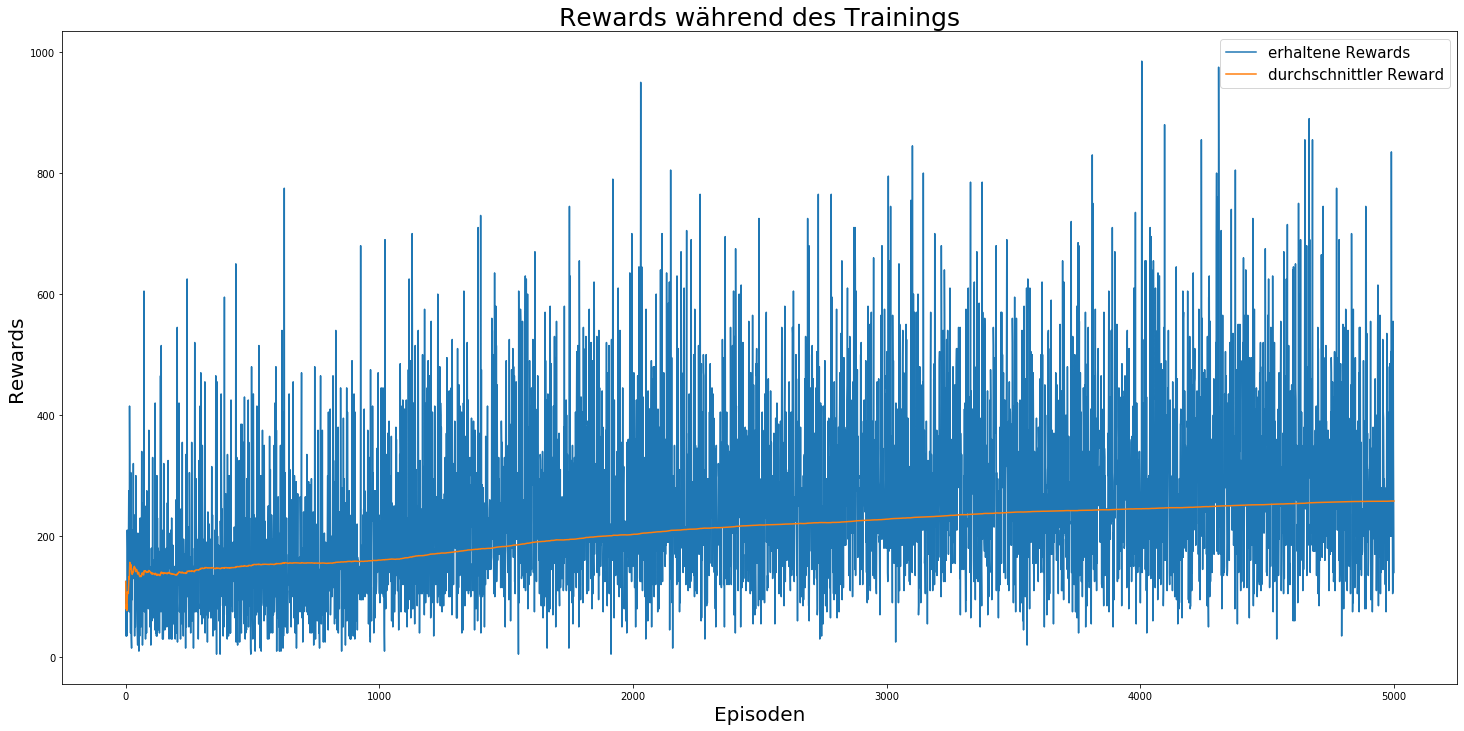

In [25]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [26]:
!ls "WEIGHTS/"

Breakout-v0		MsPacman-v0_DQN_Ep_13838.h5
MsPacman-v0_DQN_End.h5	SpaceInvaders-v0


In [27]:
# Gewichte laden
#WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
#DQN.load_weights(filepath=WEIGHTS_PATH)

## Rendering a Game

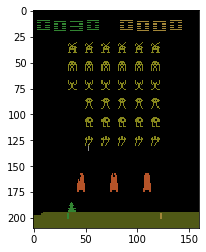

In [ ]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)